In [1]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
import matplotlib
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")
import networkx as nx
import random
import numpy as np
import utils as ut
import numpy.ma as ma
import copy
from statistics import mean
from triFastSTMF import triFastSTMF as triFastSTMF

# Import network

In [2]:
# preprocessing
def preprocess(file, day_number):
    with open(file, mode="r") as f:
        lines = f.readlines()
    weights = dict()
    
    for l in lines:
        e = l.strip().split(" ")
        if int(e[3]) <= day_number:
            key = frozenset(set((e[0], e[1])))
            if key in weights.keys():
                weights[key] += float(e[2])
            else:
                weights[key] = float(e[2])
        
    with open(f"{file}_d{day_number}", mode="w") as f:
        for key, value in weights.items(): 
            a, b = key
            f.write(f"{a} {b} {value}\n")

In [3]:
data = []
days = [1, 3, 10, 20, 30, 41]
for i in days:
    preprocess("data/insecta-ant-colony3/insecta-ant-colony3.edges", i)
    G = nx.read_edgelist(f"data/insecta-ant-colony3/insecta-ant-colony3.edges_d{i}", nodetype=int, data=(("weight", float),))
    adj = nx.adjacency_matrix(G)
    d = np.array(adj.todense().flatten())[0]
    data.append(d/i)

/var/folders/1w/wvs3yw9s1rsg8349s7lnvvj80000gn/T/ipykernel_40527/2042276949.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


In [4]:
data[1]

array([ 0.        ,  2.66666667,  3.66666667, ...,  7.33333333,
       14.66666667,  0.        ])

In [5]:
def plot_distributions_by_days(data, nrows = 2, ncols = 3, bins=25):
    bins = [0., 3.592, 7.184, 10.776, 14.368, 17.96, 21.552, 25.144, 28.736, 32.328,
            35.92, 39.512, 43.104, 46.696, 50.288, 53.88, 57.472, 61.064, 64.656, 68.248,
            71.84, 75.432, 79.024, 82.616, 86.208, 89.8]
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 6))
    counter = 0
#     print(np.max(data))
    for i in range(nrows):
        for j in range(ncols):
#             print(bins)
            _, _, _ = axs[i][j].hist(data[counter], bins = bins)#, density=True)
            axs[i][j].set_xlim((0, 90))
            axs[i][j].set_ylim((0, 19000))
            if counter == 0:
                axs[i][j].set_title(f"{days[counter]} day")
            else:
                axs[i][j].set_title(f"{days[counter]} days")
            counter += 1
            if j==0:
                axs[i][j].set_ylabel("frequency")
            if i==1:
                axs[i][j].set_xlabel("weights")
    fig.tight_layout()
    fig.savefig("data/distributions_by_days.png")

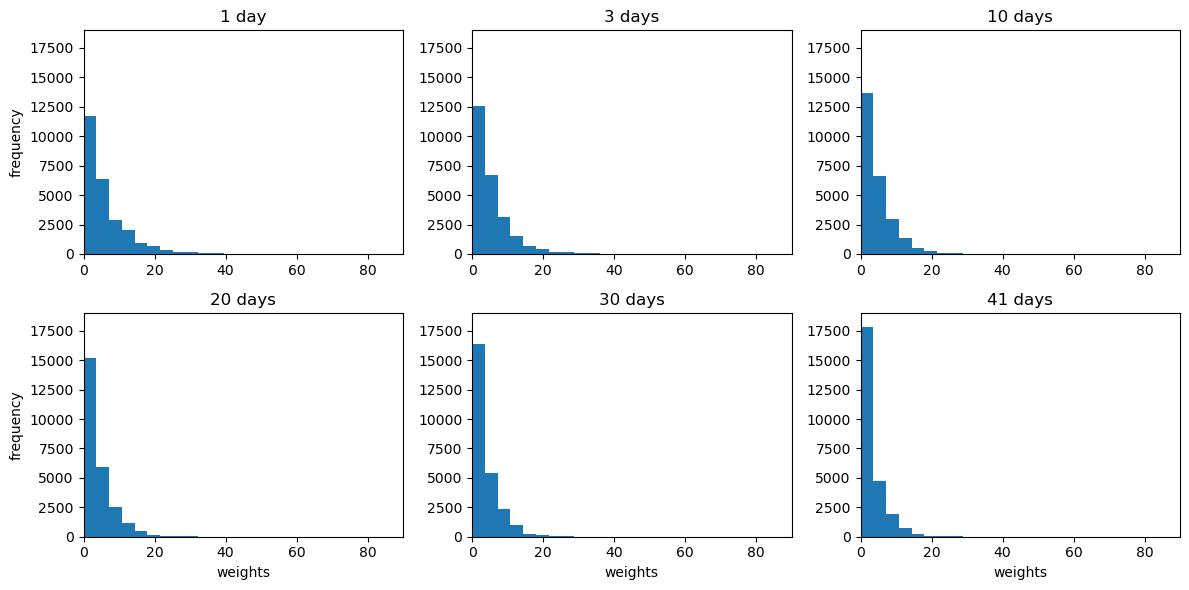

In [6]:
plot_distributions_by_days(data)

## Analysis of adjacency matrices, day by day separately

In [7]:
# preprocessing
def preprocess_for_specific_day(file, day_number):
    with open(file, mode="r") as f:
        lines = f.readlines()
    #weights = dict()
    
    adj_matrix = np.zeros((160, 160))
    for l in lines:
        e = l.strip().split(" ")
        if int(e[3]) == day_number:
            adj_matrix[int(e[0])-1][int(e[1])-1] = float(e[2])
            adj_matrix[int(e[1])-1][int(e[0])-1] = float(e[2])
    indices = np.triu_indices(160, 1)
    return adj_matrix, adj_matrix[indices]

# CREATING ADJACENCY BY DAYS

In [8]:
data = np.zeros((12720, 41))
days = range(41)
for i in days:
    #print(i)
    _, adj = preprocess_for_specific_day("data/insecta-ant-colony3/insecta-ant-colony3.edges", i+1)
    #print(full_adj.shape)
    data[:,i]=adj
data

array([[ 3.,  0.,  5., ...,  3.,  3.,  0.],
       [ 7.,  2.,  4., ...,  0.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [13., 10.,  8., ...,  0.,  0.,  0.],
       [ 7.,  8.,  7., ...,  0.,  0.,  0.],
       [22., 14.,  8., ...,  0.,  0.,  0.]])

In [9]:
max(data[:,-1])

102.0

In [10]:
header = ",".join([f"Day {i + 1}" for i in range(41)])
header

'Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21,Day 22,Day 23,Day 24,Day 25,Day 26,Day 27,Day 28,Day 29,Day 30,Day 31,Day 32,Day 33,Day 34,Day 35,Day 36,Day 37,Day 38,Day 39,Day 40,Day 41'

In [11]:
np.savetxt("data/adjacency_by_days.csv", data, delimiter=",", header=header)

In [12]:
mat = np.array([[1,2,3], [0, 4,5], [7,8,1]])
mat

array([[1, 2, 3],
       [0, 4, 5],
       [7, 8, 1]])

In [13]:
indices = np.triu_indices(3, 1)
indices

(array([0, 0, 1]), array([1, 2, 2]))

In [14]:
mat[indices]

array([2, 3, 5])

## Selecting our datasets

### Days 1 - 19

In [15]:
min_day, max_day = 1, 19
avg_adj = np.zeros((160, 160))
days = list(range(min_day, max_day + 1))
for i in days:
    full_adj, _ = preprocess_for_specific_day("data/insecta-ant-colony3/insecta-ant-colony3.edges", i+1)
    avg_adj += full_adj
avg_adj /= len(days)

In [16]:
np.savetxt(f"data/avg_adj_{min_day}_{max_day}.csv", avg_adj, delimiter=",")
header = [f"Ant {i + 1}" for i in range(160)]
with open(f"data/avg_adj_{min_day}_{max_day}.csv", mode="r") as f:
    lines = f.readlines()
with open(f"data/avg_adj_{min_day}_{max_day}.csv", mode="w") as f:
    f.write(f"{','.join(header)}\n")
    f.write(f"{','.join(['c' for _ in range(160)])}\n")
    f.write("\n")
    for l in lines:
        f.write(l)

### Days 20 - 31

In [17]:
min_day, max_day = 20, 31
avg_adj = np.zeros((160, 160))
days = list(range(min_day, max_day + 1))
for i in days:
    full_adj, _ = preprocess_for_specific_day("data/insecta-ant-colony3/insecta-ant-colony3.edges", i+1)
    avg_adj += full_adj
avg_adj /= len(days)

In [18]:
np.savetxt(f"data/avg_adj_{min_day}_{max_day}.csv", avg_adj, delimiter=",")
header = [f"Ant {i + 1}" for i in range(160)]
with open(f"data/avg_adj_{min_day}_{max_day}.csv", mode="r") as f:
    lines = f.readlines()
with open(f"data/avg_adj_{min_day}_{max_day}.csv", mode="w") as f:
    f.write(f"{','.join(header)}\n")
    f.write(f"{','.join(['c' for _ in range(160)])}\n")
    f.write("\n")
    for l in lines:
        f.write(l)

### Days 32 - 41

In [19]:
min_day, max_day = 32, 41
avg_adj = np.zeros((160, 160))
days = list(range(min_day, max_day + 1))
for i in days:
    full_adj, _ = preprocess_for_specific_day("data/insecta-ant-colony3/insecta-ant-colony3.edges", i+1)
    avg_adj += full_adj
avg_adj /= len(days)

In [20]:
np.savetxt(f"data/avg_adj_{min_day}_{max_day}.csv", avg_adj, delimiter=",")
header = [f"Ant {i + 1}" for i in range(160)]
with open(f"data/avg_adj_{min_day}_{max_day}.csv", mode="r") as f:
    lines = f.readlines()
with open(f"data/avg_adj_{min_day}_{max_day}.csv", mode="w") as f:
    f.write(f"{','.join(header)}\n")
    f.write(f"{','.join(['c' for _ in range(160)])}\n")
    f.write("\n")
    for l in lines:
        f.write(l)